In [28]:
import os
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler


os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200


In [3]:
@np.vectorize
def bgs_rec(mu, s, r, L):
    return np.exp(-L * mu/(s*(1+(1-s)*r/s)**2))

In [4]:
bgs_rec(1e-8, 1e-3, 1e-8, 1e3)

array(0.99005003)

## Data

In [454]:
sim_data = np.load('../data/slim_sims/B_data.npz', allow_pickle=True)

In [455]:
sim_data['features'], sim_data['X'].shape

(array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'),
 (31137, 7))

In [456]:
X, y = np.array(sim_data['X']), sim_data['y']

In [457]:
# how strong is selection?
(X[:, 1] > 1e-3).mean()

0.6714519703246941

In [458]:
X_train, X_test, y_train, y_test = train_test_split(X[:, (1, 3, 4)], y[:, 1],  test_size=0.10, random_state=1)

X_scaler = StandardScaler().fit(X_train)
X_train_normalized = X_scaler.transform(X_train)

In [459]:
X_bounds = np.stack((X_train.min(axis=0), X_train.max(axis=0))).T
X_bounds

array([[1.000e-04, 9.999e-02],
       [5.979e-09, 1.000e-05],
       [1.000e-08, 1.000e-06]])

In [460]:
bdist = np.stack((np.abs(X_test - X_bounds[:, 0]), np.abs(X_test - X_bounds[:, 1]))).min(axis=0).sum(axis=1)

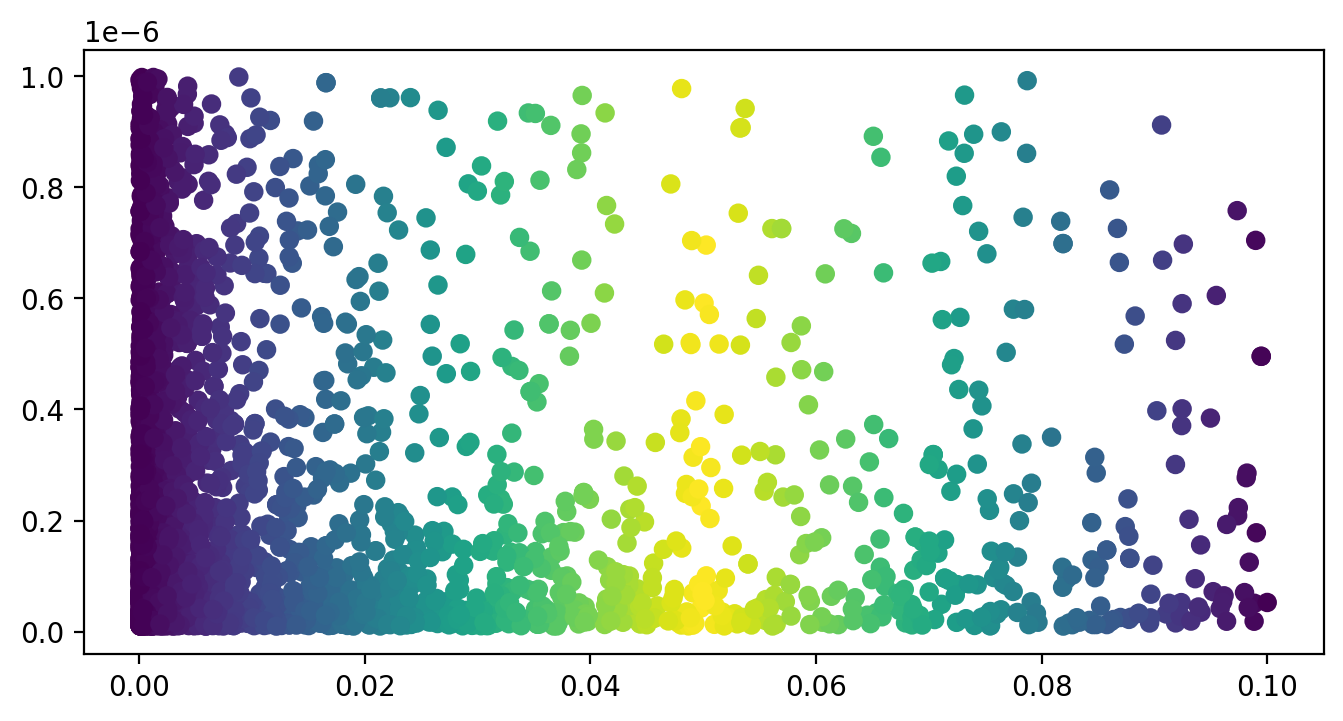

In [461]:
plt.scatter(X_test[:, 0], X_test[:, 2], c=bdist)

In [462]:
X_test_normalized = X_scaler.transform(X_test)

In [463]:
X_train.shape, y_train.shape

((28023, 3), (28023,))

In [464]:
def network(n64=0, n32=6, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(3,)))
    #model.add(layers.BatchNormalization(axis=1))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
        #model.add(layers.Dropout(0.2))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
        #model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [465]:
model = network()
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(X_train_normalized, y_train, 
                    validation_split=0.1, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=500, verbose=0, callbacks=[es, tqdm_callback])

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 142.
Epoch 00192: early stopping


In [466]:
predict = model.predict(X_test_normalized)

In [467]:
y_test.shape, predict.shape

((3114,), (3114, 1))

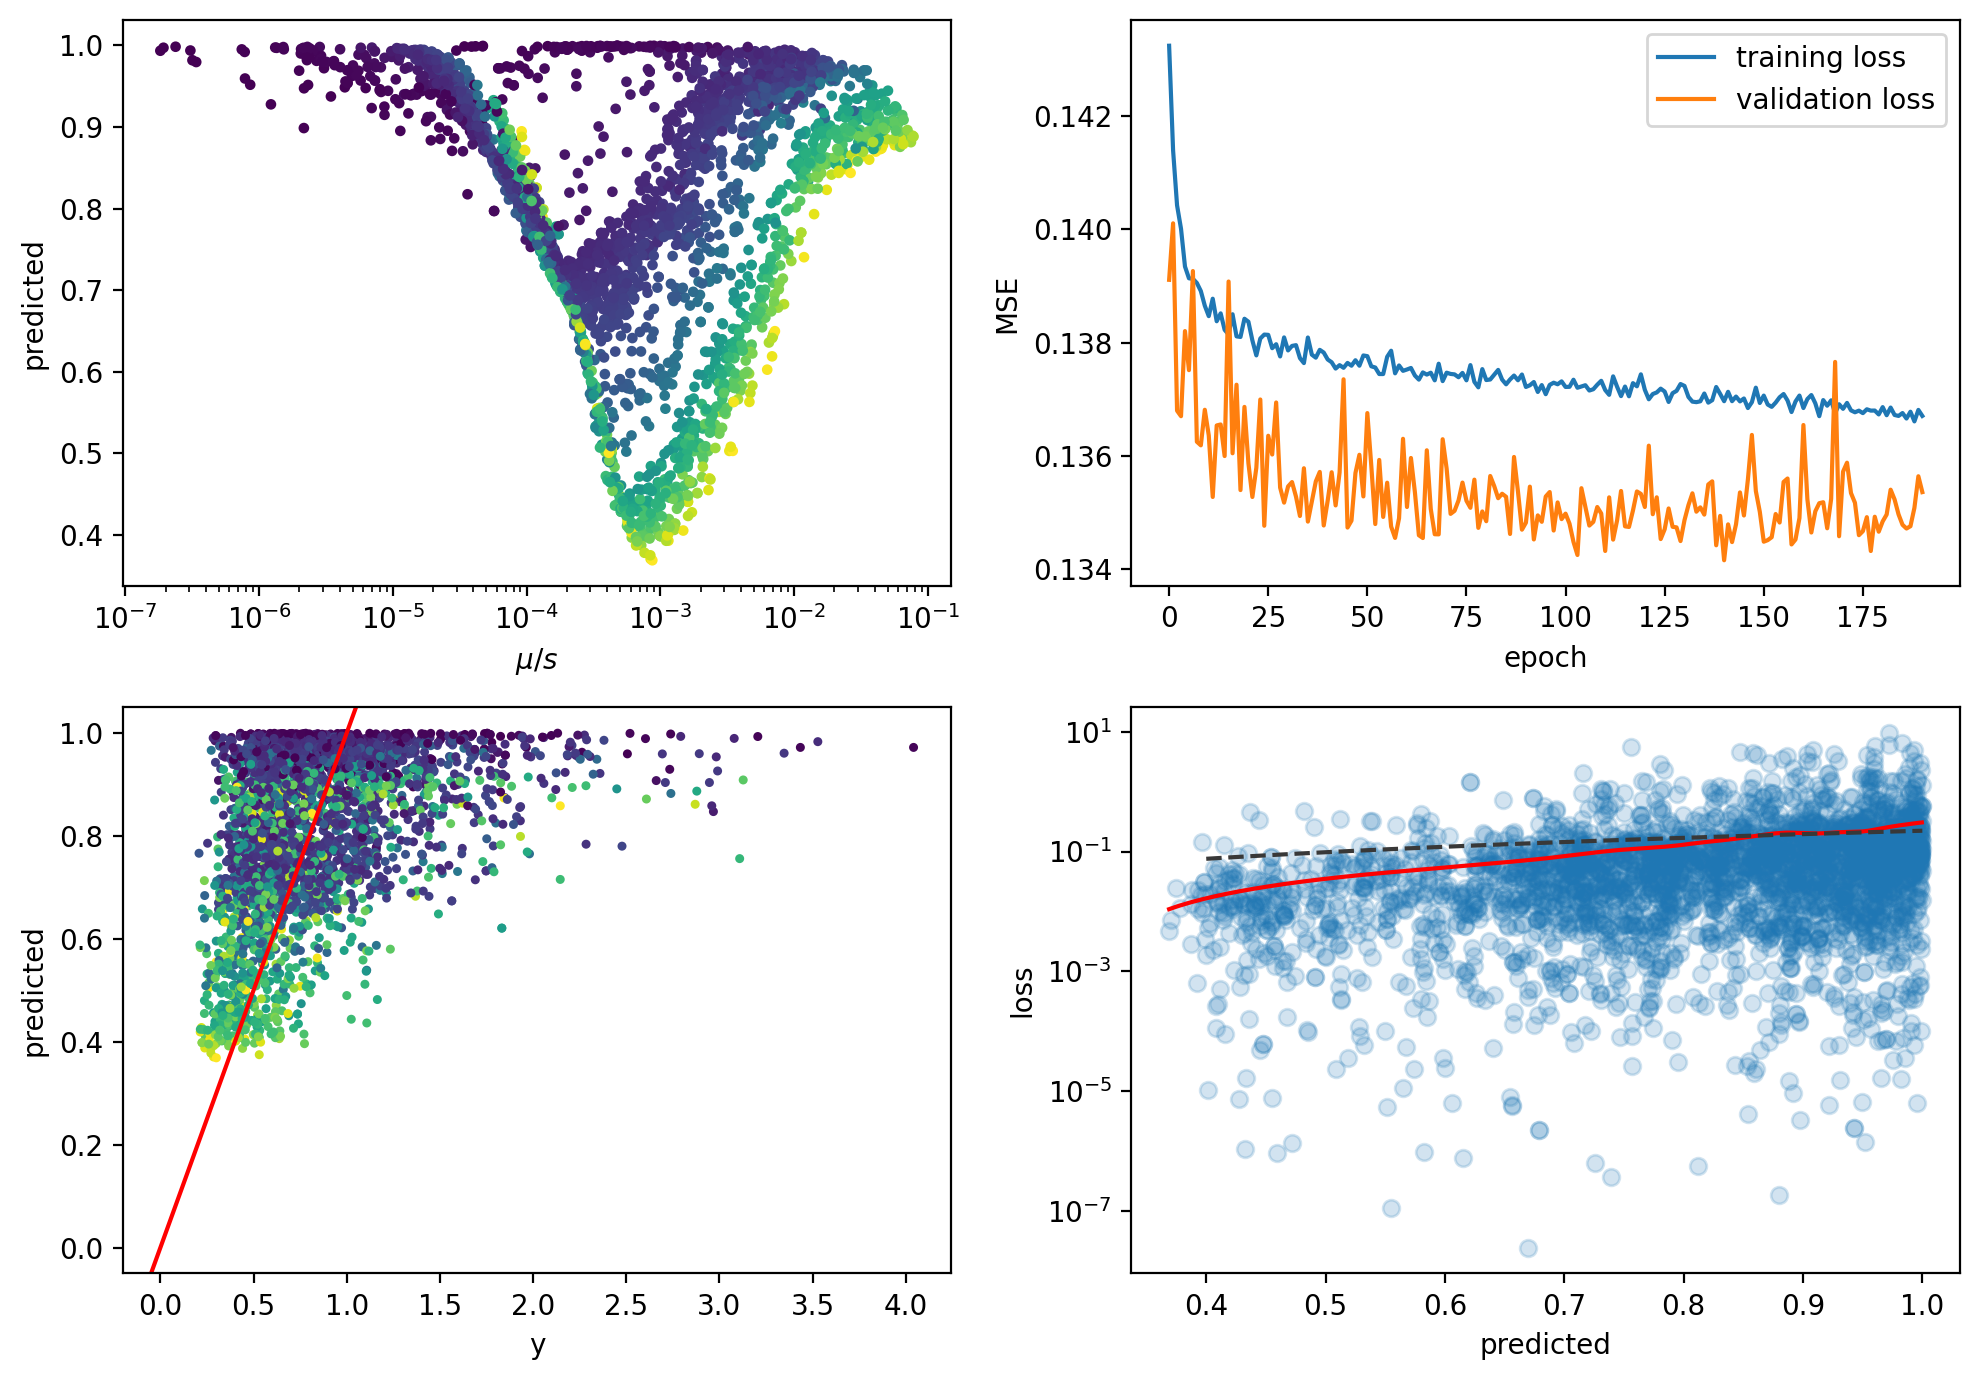

In [473]:
y_theory = bgs_rec(X_test[:, 1], X_test[:, 0], X_test[:, 2], 1000)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))
#ax1.scatter(X_test[:, 1]/X_test[:, 0], predict, c=np.abs(y_test - predict.flatten()))
ax1.scatter(X_test[:, 1]/X_test[:, 0], predict, c=X_test[:, 1], s=8)
ax3.scatter(y_test, predict, c=X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r')
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ax4.scatter(predict.flatten(), (predict.flatten() - y_test)**2, alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess((predict.flatten() - y_test)**2, predict.flatten(), frac= 1./3, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r')
xnew = np.linspace(0.4, 1, 100)
def taj(theta):
    return 1/9*(3*theta + 2*theta**2)
ax4.plot(xnew, taj(xnew/2), c='0.22', linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
ax4.set_yscale('log')
ax4.set_ylabel('loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.set_xscale('log')
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

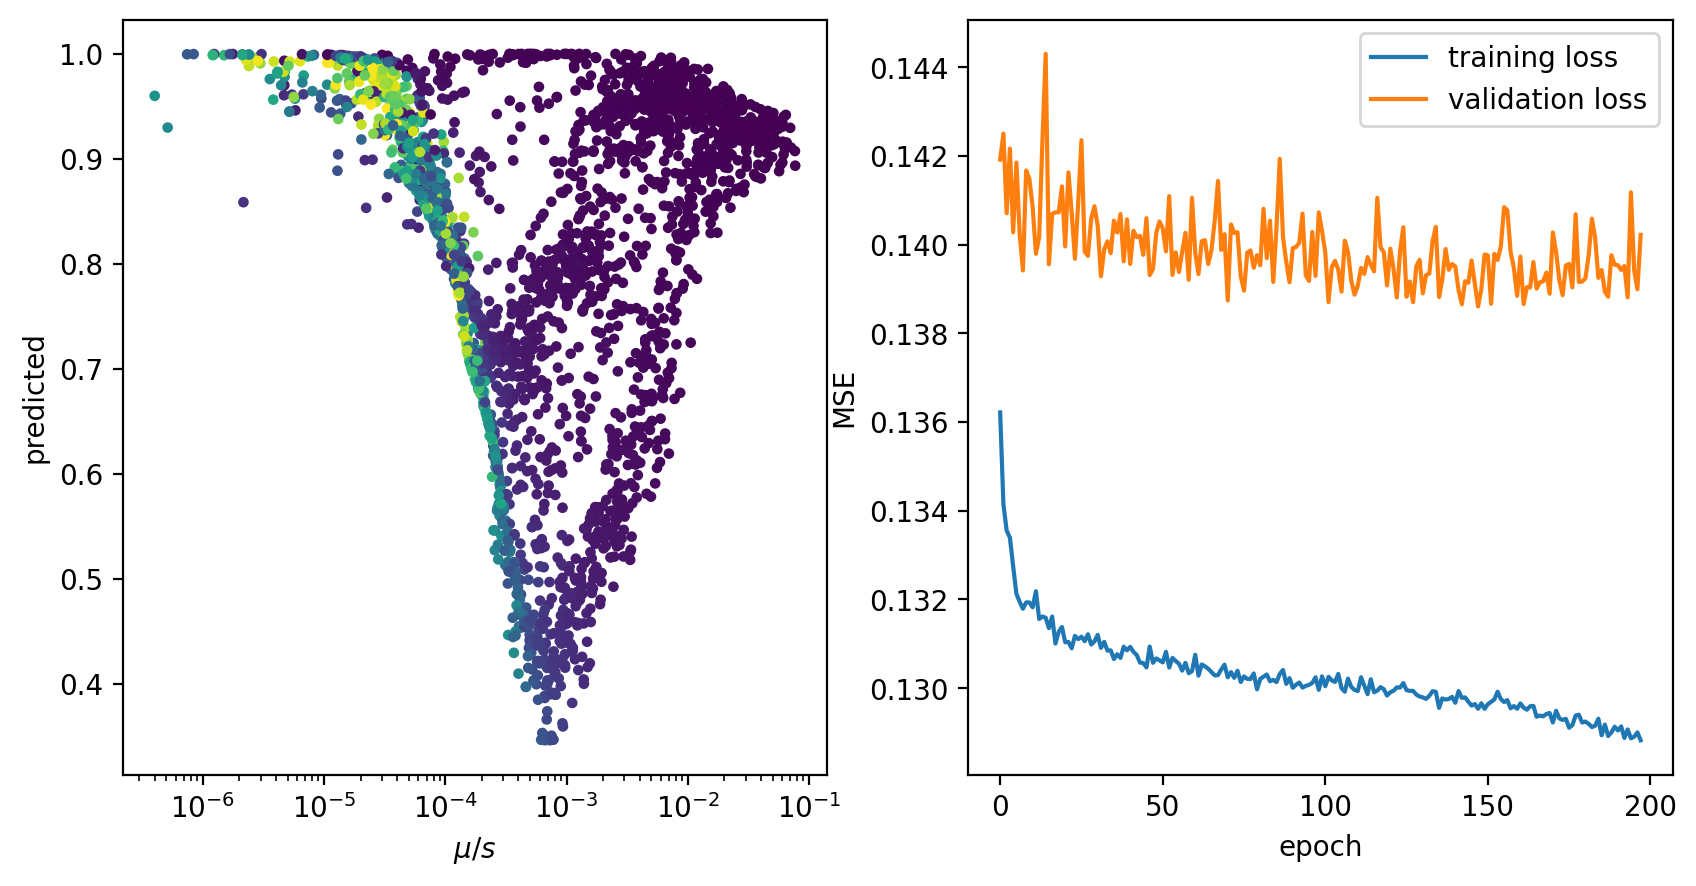

In [408]:
y_theory = bgs_rec(X_test[:, 1], X_test[:, 0], X_test[:, 2], 1000)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#ax1.scatter(X_test[:, 1]/X_test[:, 0], predict, c=np.abs(y_test - predict.flatten()))
ax1.scatter(X_test[:, 1]/X_test[:, 0], predict, c=bdist, s=8)
#ax1.scatter(y_theory, predict, c=X_test[:, 2])
#ax1.axline((0, 0), slope=1, c='r')
ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.set_xscale('log')
#ax2.set_ylim((0, 1))
ax2.legend()

In [283]:
model.evaluate(X_test_normalized, y_test)

61/61 [==============================] - 0s 2ms/step - loss: 0.1419 - mean_absolute_error: 0.2605


[0.14185424149036407, 0.2605266869068146]

In [55]:
model.evaluate(X_test_normalized, y_test)

3125/3125 [==============================] - 5s 2ms/step - loss: 0.1446 - mean_absolute_error: 0.2683


[0.1446310430765152, 0.2682616710662842]

In [284]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(0.26052667821272607, 0.40324143167388765)

In [171]:
np.abs(predict.flatten() - y_test.flatten()).mean(), np.abs(predict.flatten() - y_theory.flatten()).mean()

(5.392334013709564e-06, 0.9286115050067685)

(array([  86., 1026., 3738., 6127., 5709., 3269., 1272.,  295.,   27.,
           8.]),
 array([-0.62505611, -0.48181238, -0.33856864, -0.1953249 , -0.05208117,
         0.09116257,  0.23440631,  0.37765004,  0.52089378,  0.66413752,
         0.80738125]),
 <BarContainer object of 10 artists>)

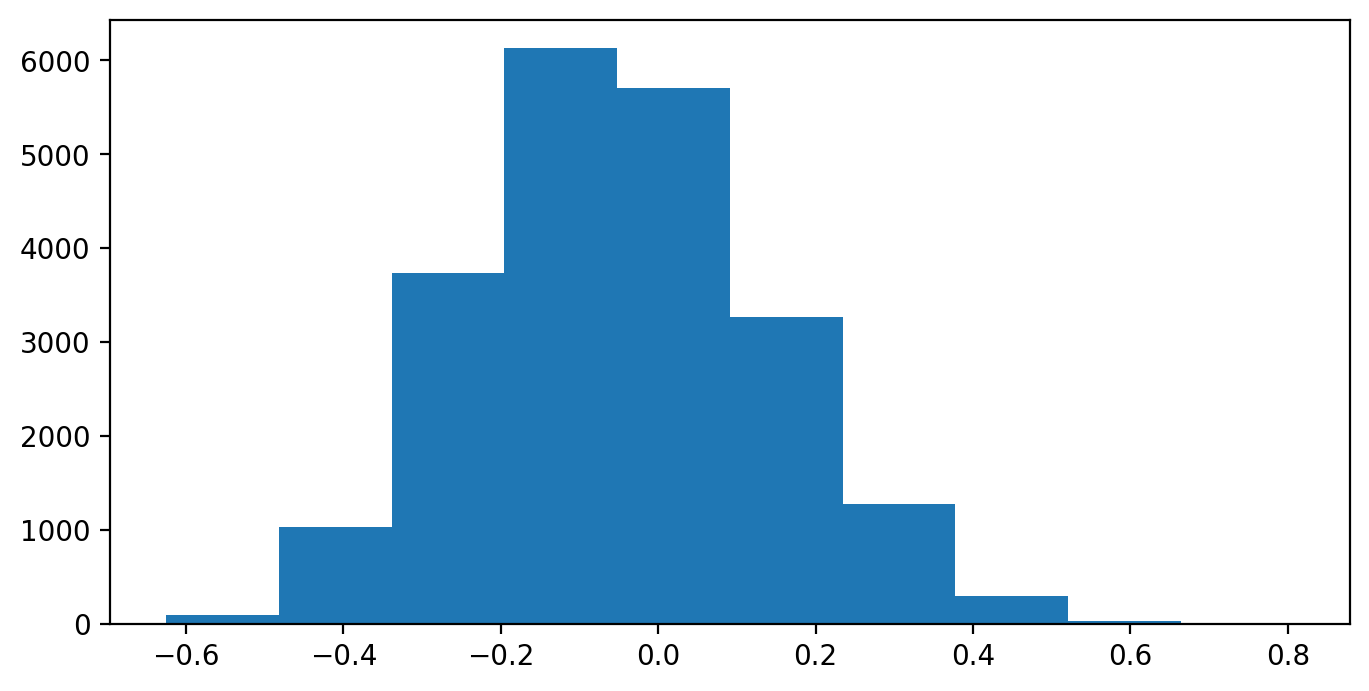

In [202]:
fig, ax = plt.subplots()
ax.hist(np.log10(y[:, 1].flatten()))

Text(0, 0.5, 'B')

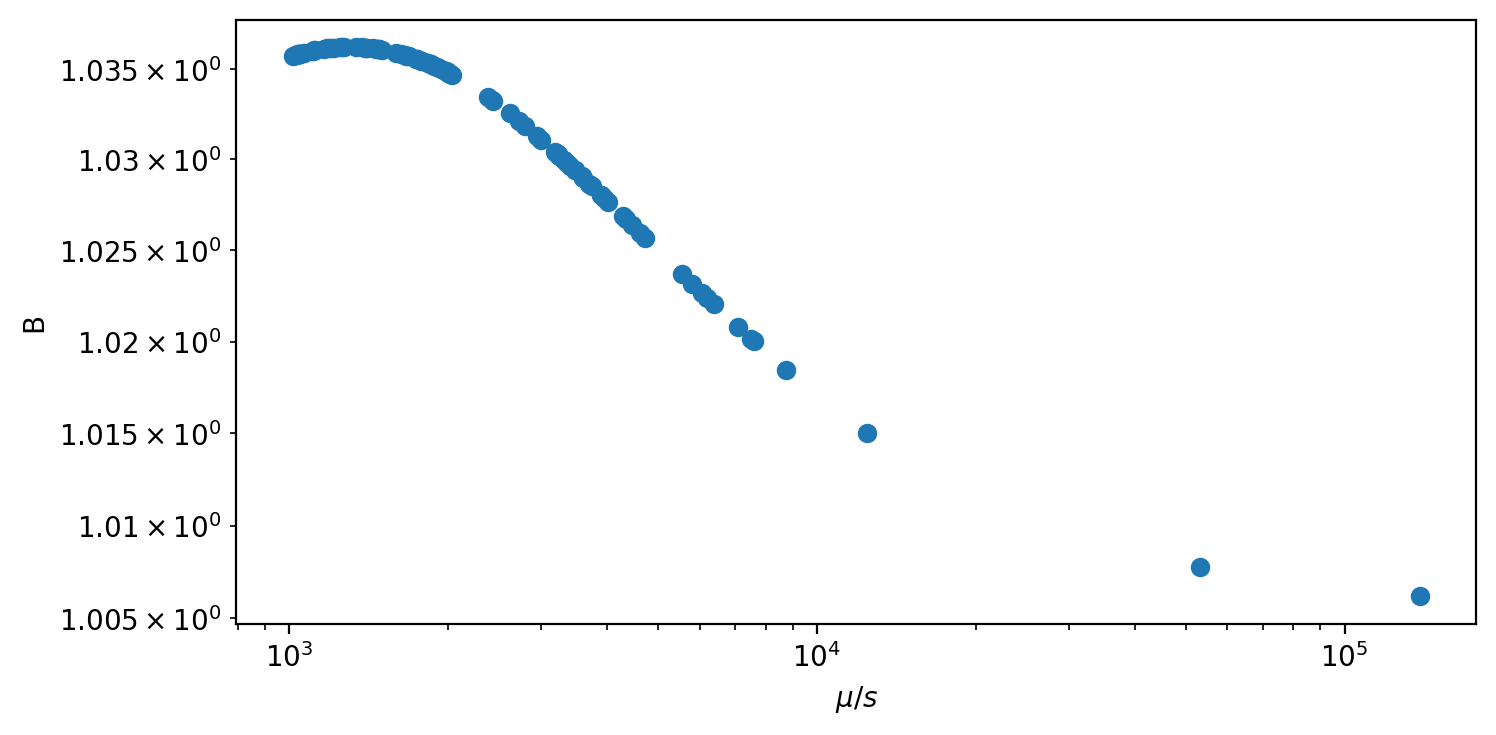

In [245]:
n = 100
mu = np.random.uniform(1e-8, 1e-8, n)
s = np.random.uniform(1e-6, 1e-1, n)
#rbp = np.random.uniform(1e-7, 1e-9, n)
rbp = np.repeat(1e-8, n)
#recfrac = np.random.uniform(1e-7, 1e-3, n)
recfrac = np.repeat(1e-8, n)
#L = np.random.uniform(10, 100_000, n)
L = np.repeat(1000, n)
#N = np.random.uniform(50, 10_000, n)
N = np.repeat(100, n)
#xnew = np.array((mu, s, rbp, N, L)).T
#'N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'
xnew = np.array((N, s, mu, recfrac, rbp, L)).T
rate = xnew[:, 0]/xnew[:, 1]
fig, ax = plt.subplots()
ax.scatter(rate, model.predict(X_scaler.transform(xnew)))
#ax.scatter(rate, bgs_rec(mu, s, rbp, L))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\mu/s$')
ax.set_ylabel('B')

In [105]:
tf.reduce_mean(np.abs(predict.flatten() - y_theory.flatten()))

<tf.Tensor: shape=(), dtype=float64, numpy=0.007151165998975198>

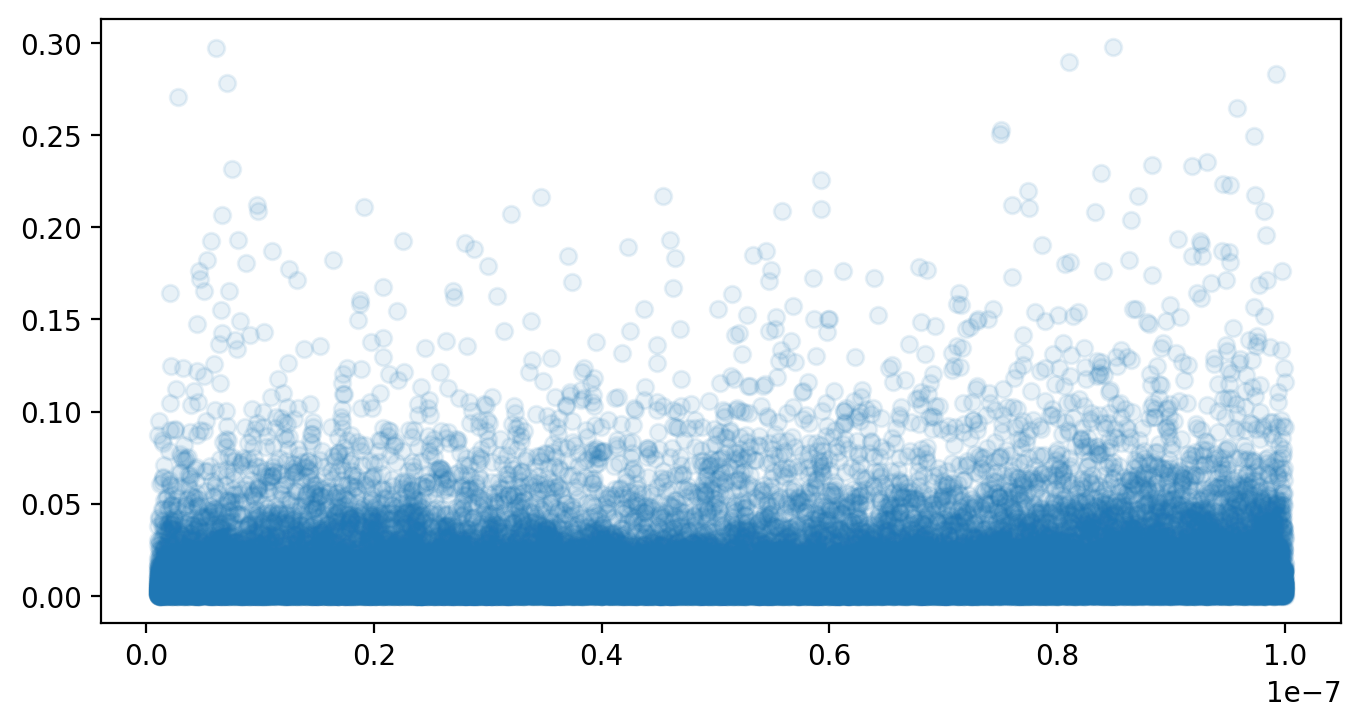

In [ ]:
plt.scatter(X_test[:, 3], np.abs(predict.flatten() - y_theory.flatten()), alpha=0.1)

In [212]:
dat = np.load('/home/vsb/projects/bprime/data/slim_sims/B_data.npz')

In [213]:
X, y, features = dat['X'], dat['y'], dat['features']

In [214]:
X, features

(array([[1.000e+03, 3.560e-02, 5.000e-01, ..., 1.714e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 5.710e-03, 5.000e-01, ..., 1.425e-07, 1.100e-08,
         1.000e+03],
        [1.000e+03, 3.101e-03, 5.000e-01, ..., 7.648e-08, 1.100e-08,
         1.000e+03],
        ...,
        [1.000e+03, 4.264e-04, 5.000e-01, ..., 4.197e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.066e-02, 5.000e-01, ..., 8.634e-08, 1.100e-08,
         1.000e+03],
        [1.000e+03, 1.393e-02, 5.000e-01, ..., 3.009e-08, 1.100e-08,
         1.000e+03]]),
 array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'))

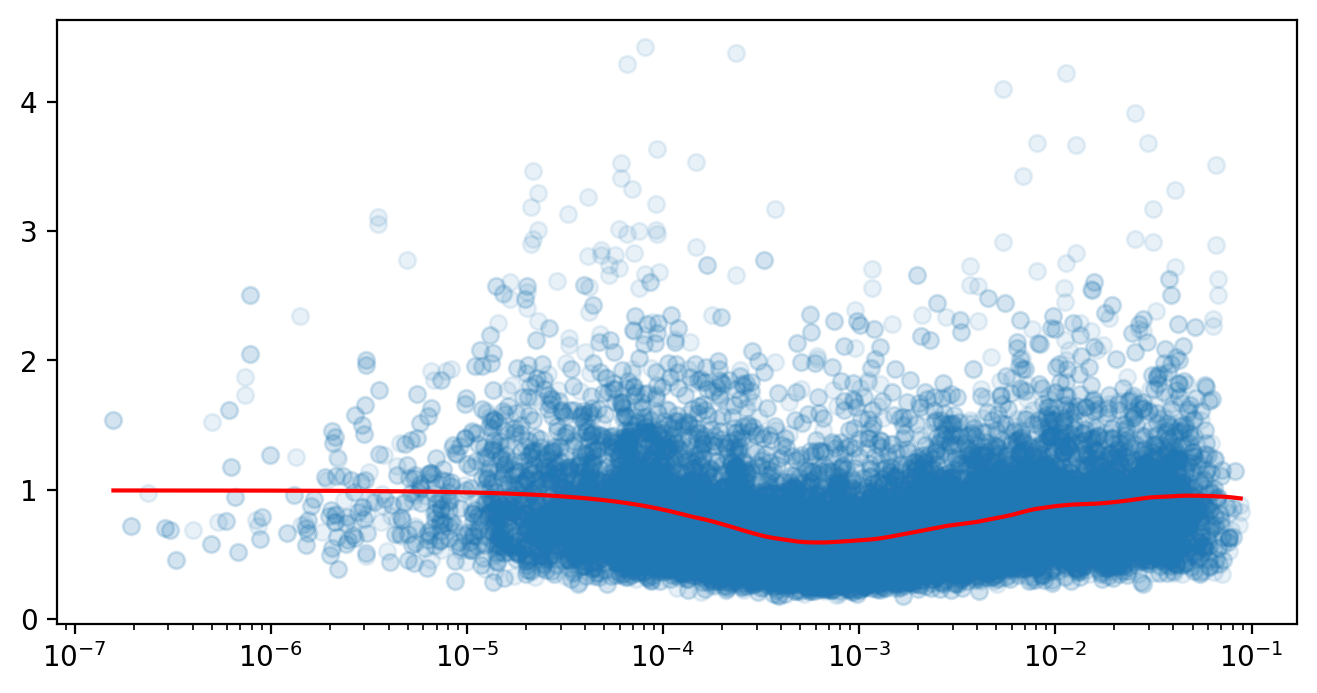

In [215]:
idx = X[:, 4] < 1
rate = X[idx, 3]/X[idx, 1]
yy = y[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)
lowess = sm.nonparametric.lowess

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [216]:
X.shape, y.shape


((19517, 7), (19517, 5))

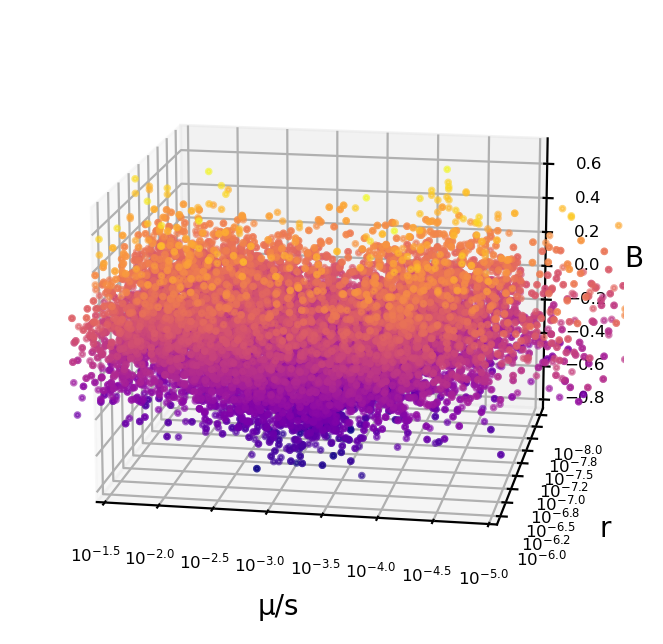

In [260]:
import matplotlib.ticker as mticker

def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=np.log10(y[:, 1]), alpha=0.6, cmap='plasma')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
ax.tick_params(axis='both', which='major', labelsize=6)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))


In [218]:
from sklearn.kernel_ridge import KernelRidge

In [234]:
krr = KernelRidge(gamma=0.1, kernel='rbf')
features = np.stack((X[:, 3]/X[:, 1], X[:, 4])).T
krrm = krr.fit(features, y[:, 1])

Text(0.5, 0, 'B')

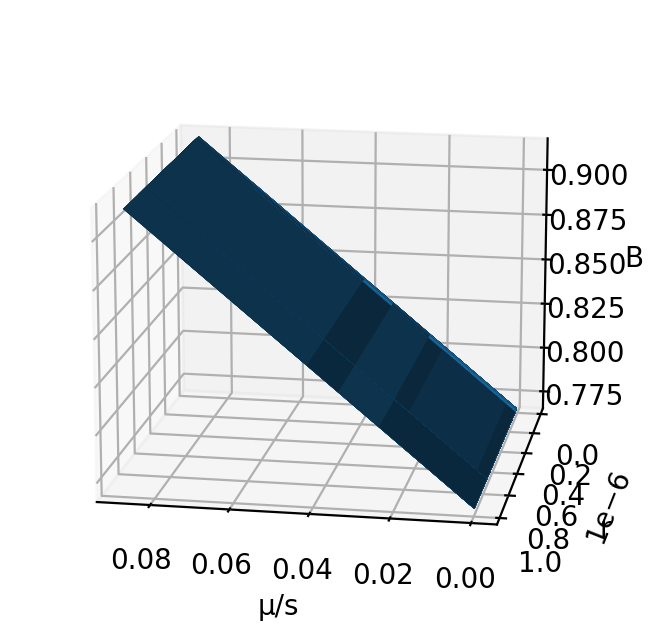

In [235]:
n = 100
xnew = 10**np.random.uniform(-5, -1, n)
ynew = 10**np.random.uniform(-8, -6, n)
Xg, Yg = np.meshgrid(xnew, ynew)
ynew = krrm.predict(np.stack((Xg.flatten(), Yg.flatten())).T).reshape(Xg.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.scatter(np.log10(X[:, 3]/X[:, 1]), np.log10(X[:, 4]), np.log10(y[:, 1]), s=3, c=y[:, 1], alpha=0.6, cmap='viridis')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')
ax.plot_surface(Xg, Yg, ynew)
#ax.view_init(5, 270)
ax.view_init(15, 100)
#ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
#ax.tick_params(axis='both', which='major', labelsize=6)
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.yaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
#ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
